In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Warm-up

In [11]:
df_citibike = pd.read_csv("JC-202307-citibike-tripdata.csv")

In [12]:
df_citibike.started_at = pd.to_datetime(df_citibike.started_at)
df_citibike.ended_at = pd.to_datetime(df_citibike.ended_at)

In [13]:
df_citibike.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7A68381621C25F78,classic_bike,2023-07-17 17:16:34,2023-07-17 17:20:52,Astor Place,JC077,Communipaw & Berry Lane,JC084,40.719225,-74.071281,40.714358,-74.066611,member
1,0F814CA67B2FA120,classic_bike,2023-07-26 19:40:15,2023-07-26 19:44:37,Adams St & 2 St,HB407,9 St HBLR - Jackson St & 8 St,HB305,40.739727,-74.036866,40.747907,-74.038412,member
2,775A38967EBF5FB4,electric_bike,2023-07-01 12:12:22,2023-07-01 12:27:45,McGinley Square,JC055,Riverview Park,JC057,40.725340,-74.067622,40.744319,-74.043991,member
3,D93B742DCE1C1447,classic_bike,2023-07-20 19:10:18,2023-07-20 19:17:22,Baldwin at Montgomery,JC020,Brunswick St,JC023,40.723455,-74.064359,40.724176,-74.050656,member
4,AA7A6863B4B92169,electric_bike,2023-07-07 19:33:59,2023-07-07 19:58:17,Baldwin at Montgomery,JC020,Mama Johnson Field - 4 St & Jackson St,HB404,40.723659,-74.064194,40.743140,-74.040041,casual


In [14]:
df_citibike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106608 entries, 0 to 106607
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ride_id             106608 non-null  object        
 1   rideable_type       106608 non-null  object        
 2   started_at          106608 non-null  datetime64[ns]
 3   ended_at            106608 non-null  datetime64[ns]
 4   start_station_name  106601 non-null  object        
 5   start_station_id    106601 non-null  object        
 6   end_station_name    106216 non-null  object        
 7   end_station_id      106216 non-null  object        
 8   start_lat           106608 non-null  float64       
 9   start_lng           106608 non-null  float64       
 10  end_lat             106486 non-null  float64       
 11  end_lng             106486 non-null  float64       
 12  member_casual       106608 non-null  object        
dtypes: datetime64[ns](2), float64

In [21]:
df_citibike["duration"] = (df_citibike.ended_at - df_citibike.started_at).dt.total_seconds() / 60

In [22]:
df_citibike.duration

0          4.300000
1          4.366667
2         15.383333
3          7.066667
4         24.300000
            ...    
106603    12.766667
106604     4.000000
106605     6.483333
106606     8.083333
106607    11.283333
Name: duration, Length: 106608, dtype: float64

In [23]:
df_citibike = df_citibike[df_citibike.duration < 60*3]

## Duration Histogram

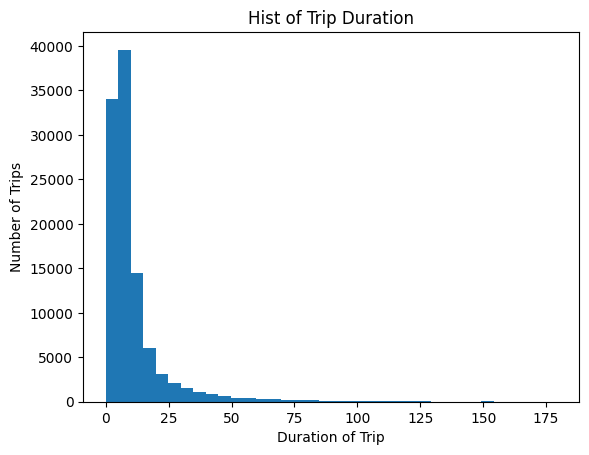

In [30]:
plt.hist(df_citibike.duration, bins=3*60//5)
plt.title("Hist of Trip Duration")
plt.xlabel("Duration of Trip")
plt.ylabel("Number of Trips")
plt.show()

## Average Ride Duration, Variance, and $\mathbb{P}$(Duration $>$ 20)

## $\mathbb{P}$(Duration > 20 | CitiBike Member)

## $\mathbb{P}$(CitiBike Member | Duration > 25)

## Expected duration of Electric Bike vs. Classic Bike

## $\mathbb{P}$(Electric Bike | Duration < 10) and $\mathbb{P}$(Classic Bike | Duration < 10)